In [55]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

In [56]:
data = pd.read_csv('Provisional_Death_Counts_for_Influenza__Pneumonia__and_COVID-19.csv',sep=',', index_col = 0, na_values = "na")


In [57]:
data.drop(['End Week', 'MMWRyear', 'MMWRweek', 'Group', 'Indicator',
          'Total Deaths',
        'Pneumonia or Influenza',
       'Pneumonia, Influenza, or COVID-19 Deaths', 'Footnote'], axis=1, inplace = True)

In [58]:
data_age=data.loc[data['Age Group'] == 'All Ages']

In [59]:
data2_final = pd.read_csv('all-states-history_final.csv',sep=',', index_col = 0, na_values = "na")

data2_final.head

<bound method NDFrame.head of            state  death  deathConfirmed  deathIncrease  deathProbable  \
date                                                                    
12/14/2020    AK    184             184              8              0   
12/14/2020    AL   4389            3849            287            540   
12/14/2020    AR   3237            2842            292            395   
12/14/2020    AS      0               0              0              0   
12/14/2020    AZ   7971            7277            614            694   
...          ...    ...             ...            ...            ...   
01/27/2020    MA      0               0              0              0   
01/27/2020    WA      0               0              0              0   
01/20/2020    MA      0               0              0              0   
01/20/2020    WA      0               0              0              0   
01/13/2020    WA      0               0              0              0   

            hospital

In [60]:
data2_final = data2_final.iloc[::-1]
data2_final.head

<bound method NDFrame.head of            state  death  deathConfirmed  deathIncrease  deathProbable  \
date                                                                    
01/13/2020    WA      0               0              0              0   
01/20/2020    WA      0               0              0              0   
01/20/2020    MA      0               0              0              0   
01/27/2020    WA      0               0              0              0   
01/27/2020    MA      0               0              0              0   
...          ...    ...             ...            ...            ...   
12/14/2020    AZ   7971            7277            614            694   
12/14/2020    AS      0               0              0              0   
12/14/2020    AR   3237            2842            292            395   
12/14/2020    AL   4389            3849            287            540   
12/14/2020    AK    184             184              8              0   

            hospital

In [61]:
data_final = data2_final.append(data_age)

In [62]:
data_final_model=data_final.filter(['Jurisdiction','death', 
                                    'Pneumonia Deaths', 'Influenza Deaths','hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently',
                                    'hospitalizedIncrease'])
data_final_model.head

<bound method NDFrame.head of              Jurisdiction  death  Pneumonia Deaths  Influenza Deaths  \
01/13/2020            NaN    0.0               NaN               NaN   
01/20/2020            NaN    0.0               NaN               NaN   
01/20/2020            NaN    0.0               NaN               NaN   
01/27/2020            NaN    0.0               NaN               NaN   
01/27/2020            NaN    0.0               NaN               NaN   
...                   ...    ...               ...               ...   
11/25/2020   HHS Region 6    NaN             107.0               0.0   
11/25/2020   HHS Region 7    NaN              96.0               0.0   
11/25/2020   HHS Region 8    NaN              31.0               0.0   
11/25/2020   HHS Region 9    NaN             182.0               NaN   
11/25/2020  HHS Region 10    NaN              47.0               0.0   

            hospitalized  hospitalizedCumulative  hospitalizedCurrently  \
01/13/2020           0.0      

In [63]:
data_final_model['Jurisdiction_cat']=data_final_model['Jurisdiction'].astype('category')
data_final_model['Jurisdiction_int']=data_final_model['Jurisdiction_cat'].cat.codes
data_final_model=data_final_model.filter(['Jurisdiction_int','death', 
                                    'Pneumonia Deaths', 'Influenza Deaths','hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently',
                                    'hospitalizedIncrease'])
data_final_model.columns
data_final_model.head

<bound method NDFrame.head of             Jurisdiction_int  death  Pneumonia Deaths  Influenza Deaths  \
01/13/2020                -1    0.0               NaN               NaN   
01/20/2020                -1    0.0               NaN               NaN   
01/20/2020                -1    0.0               NaN               NaN   
01/27/2020                -1    0.0               NaN               NaN   
01/27/2020                -1    0.0               NaN               NaN   
...                      ...    ...               ...               ...   
11/25/2020                17    NaN             107.0               0.0   
11/25/2020                18    NaN              96.0               0.0   
11/25/2020                19    NaN              31.0               0.0   
11/25/2020                20    NaN             182.0               NaN   
11/25/2020                12    NaN              47.0               0.0   

            hospitalized  hospitalizedCumulative  hospitalizedCurrent

In [64]:
data_final_model['Pneumonia Deaths'] = data_final_model['Pneumonia Deaths'].shift(-2371)
data_final_model['Influenza Deaths'] = data_final_model['Influenza Deaths'].shift(-2371)
data_final_model['Jurisdiction_int'] = data_final_model['Jurisdiction_int'].shift(-2371)

In [66]:
#data_final_model.dropna(how='any')
data_final_model=data_final_model.dropna()
data_final_model.isnull().sum().sum()

0

In [67]:
scaler = MinMaxScaler()
data_final_model_norm = pd.DataFrame(scaler.fit_transform(data_final_model), columns=data_final_model.columns)
data_final_model_norm.head

<bound method NDFrame.head of       Jurisdiction_int     death  Pneumonia Deaths  Influenza Deaths  \
0             0.887097  0.000000          0.317658          0.732416   
1             0.000000  0.000000          0.004594          0.024465   
2             0.032258  0.000000          0.005931          0.018349   
3             0.064516  0.000000          0.035583          0.090214   
4             0.096774  0.000000          0.003508          0.016820   
...                ...       ...               ...               ...   
1477          0.661290  0.200864          0.002589          0.000000   
1478          0.693548  0.813137          0.000000          0.000000   
1479          0.725806  0.000000          0.003007          0.000000   
1480          0.741935  0.116502          0.014200          0.000000   
1481          0.774194  0.006622          0.003091          0.000000   

      hospitalized  hospitalizedCumulative  hospitalizedCurrently  \
0         0.000000                0.

In [68]:
X=data_final_model_norm.filter(['Jurisdiction_int', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease'],axis=1)
y=data_final_model_norm.filter(['death'])

In [69]:
y.isna().sum()

death    0
dtype: int64

In [70]:
X.isna().sum()


Jurisdiction_int          0
hospitalized              0
hospitalizedCumulative    0
hospitalizedCurrently     0
hospitalizedIncrease      0
dtype: int64

In [71]:
X.head

<bound method NDFrame.head of       Jurisdiction_int  hospitalized  hospitalizedCumulative  \
0             0.887097      0.000000                0.000000   
1             0.000000      0.000000                0.000000   
2             0.032258      0.000000                0.000000   
3             0.064516      0.000000                0.000000   
4             0.096774      0.000000                0.000000   
...                ...           ...                     ...   
1477          0.661290      0.136196                0.136196   
1478          0.693548      0.000000                0.000000   
1479          0.725806      0.000000                0.000000   
1480          0.741935      0.116695                0.116695   
1481          0.774194      0.010389                0.010389   

      hospitalizedCurrently  hospitalizedIncrease  
0                  0.000000              0.130232  
1                  0.000000              0.130232  
2                  0.000000              0.13

In [72]:
n_features = 1
n_steps= 5
X = X.values.reshape((X.shape[0], X.shape[1], n_features))

In [73]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [74]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
1482/1482 [==============================] - 0s 170us/step - loss: 0.0278 - acc: 0.0709
Epoch 2/200
1482/1482 [==============================] - 0s 56us/step - loss: 0.0225 - acc: 0.0709
Epoch 3/200
1482/1482 [==============================] - 0s 47us/step - loss: 0.0185 - acc: 0.0709
Epoch 4/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0163 - acc: 0.0715
Epoch 5/200
1482/1482 [==============================] - 0s 53us/step - loss: 0.0151 - acc: 0.0715
Epoch 6/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0140 - acc: 0.0715
Epoch 7/200
1482/1482 [==============================] - 0s 47us/step - loss: 0.0134 - acc: 0.0715
Epoch 8/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0130 - acc: 0.0715
Epoch 9/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0133 - acc: 0.0715
Epoch 10/200
1482/1482 [==============================] - 0s 53us/step - loss: 0.0127 - acc: 0.0715
Epoch 11

Epoch 83/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0060 - acc: 0.0715  
Epoch 84/200
1482/1482 [==============================] - 0s 53us/step - loss: 0.0059 - acc: 0.0715
Epoch 85/200
1482/1482 [==============================] - 0s 47us/step - loss: 0.0060 - acc: 0.0715
Epoch 86/200
1482/1482 [==============================] - 0s 47us/step - loss: 0.0059 - acc: 0.0715
Epoch 87/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0060 - acc: 0.0715
Epoch 88/200
1482/1482 [==============================] - 0s 47us/step - loss: 0.0058 - acc: 0.0715
Epoch 89/200
1482/1482 [==============================] - 0s 53us/step - loss: 0.0058 - acc: 0.0715
Epoch 90/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0058 - acc: 0.0715
Epoch 91/200
1482/1482 [==============================] - 0s 57us/step - loss: 0.0059 - acc: 0.0715
Epoch 92/200
1482/1482 [==============================] - 0s 47us/step - loss: 0.0058 - acc: 0.071

In [75]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [79]:
history=model.fit(X, y, validation_split=0.3, epochs=15, batch_size=100, verbose=1)

Train on 1037 samples, validate on 445 samples
Epoch 1/15
1037/1037 [==============================] - 0s 50us/step - loss: 0.0055 - acc: 0.0926 - val_loss: 0.0164 - val_acc: 0.0225
Epoch 2/15
1037/1037 [==============================] - 0s 67us/step - loss: 0.0055 - acc: 0.0926 - val_loss: 0.0170 - val_acc: 0.0225
Epoch 3/15
1037/1037 [==============================] - 0s 45us/step - loss: 0.0056 - acc: 0.0926 - val_loss: 0.0170 - val_acc: 0.0225
Epoch 4/15
1037/1037 [==============================] - 0s 51us/step - loss: 0.0054 - acc: 0.0926 - val_loss: 0.0158 - val_acc: 0.0225
Epoch 5/15
1037/1037 [==============================] - 0s 60us/step - loss: 0.0059 - acc: 0.0926 - val_loss: 0.0163 - val_acc: 0.0225
Epoch 6/15
1037/1037 [==============================] - 0s 51us/step - loss: 0.0054 - acc: 0.0926 - val_loss: 0.0162 - val_acc: 0.0225
Epoch 7/15
1037/1037 [==============================] - 0s 45us/step - loss: 0.0054 - acc: 0.0926 - val_loss: 0.0163 - val_acc: 0.0225
Epoch 8/

In [80]:
history_dict = history.history

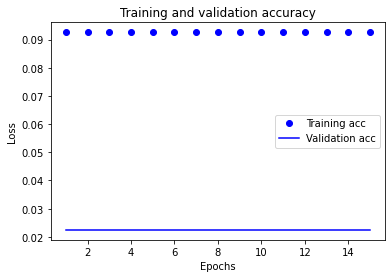

[0.00892332735186752, 0.0715249627828598]


In [81]:
import matplotlib.pyplot as plt
plt.clf()
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

results = model.evaluate(X, y, verbose = 0)
print(results)

In [226]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 50)             10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
